In [1]:
def per_section(it, is_delimiter=lambda x: x.isspace()):
    ret = []
    for line in it:
        if is_delimiter(line):
            if ret:
                yield ret  # OR  ''.join(ret)
                ret = []
        else:
            ret.append(line.rstrip())  # OR  ret.append(line)
    if ret:
        yield ret

with open('dsm_i20.txt') as f:
    sections = list(per_section(f, lambda line: line.startswith('!')))  # default delimiter

In [30]:
from stop_words import get_stop_words
from nltk.tokenize import RegexpTokenizer
import gensim
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

en_stop = get_stop_words('en')
tokenizer = RegexpTokenizer(r'\w+')
en_stop.append("ms")
en_stop.append("disorder")
en_stop.append("symptoms")
en_stop.append("mr")
en_stop.append("s")
en_stop.append("5")
en_stop.append("diagnosis")
en_stop.append("dsm")
en_stop.append("e")
en_stop.append("e_g")
en_stop.append("et")
en_stop.append("g")
en_stop.append("al")
en_stop.append("disorders")


In [20]:
dsm=[]
for i in sections:
    chap = []
    for para in i:
        raw = para.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        for k in stopped_tokens:
            chap.append(k)
    dsm.append(chap)


In [21]:
# Add bigrams and trigrams to docs (only ones that appear 2 times or more).
bigram = gensim.models.phrases.Phrases(dsm, min_count=2)
for idx in range(len(dsm)):
    for token in bigram[dsm[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            dsm[idx].append(token)
            

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [22]:
dictionary = gensim.corpora.Dictionary(dsm)
# Filter out words that occur in less than 5 documents, or more than 50% of the documents.
# dictionary.filter_extremes(no_below=1, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in dsm]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 17364
Number of documents: 223


In [25]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, iterations=50, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

In [34]:
num_topics = 13
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, iterations=50, id2word = dictionary)
top_topics = ldamodel.top_topics(corpus, topn=10)
pprint(top_topics)

[([(0.018918222, 'may'),
   (0.0080142329, 'substance'),
   (0.0076135201, 'use'),
   (0.0075102448, 'individuals'),
   (0.0051862192, 'related'),
   (0.0043741139, 'medical'),
   (0.0042590746, 'criterion'),
   (0.0039882562, 'can'),
   (0.0035077955, 'individual'),
   (0.0032307142, 'often')],
  -0.17118123145777975),
 ([(0.0098854257, 'may'),
   (0.00656805, 'individuals'),
   (0.0060794787, 'substance'),
   (0.0054820604, 'use'),
   (0.0041476851, 'onset'),
   (0.0039330036, 'medical'),
   (0.0037650415, 'major'),
   (0.0035847872, 'disturbance'),
   (0.0033764627, 'social'),
   (0.0032965739, 'can')],
  -0.24447409825302452),
 ([(0.014077382, 'sleep'),
   (0.010996695, 'may'),
   (0.0070787044, 'individuals'),
   (0.0058967117, 'social'),
   (0.0044728131, 'children'),
   (0.0040626498, 'behavior'),
   (0.0040419367, 'anxiety'),
   (0.0039279843, 'use'),
   (0.0035502918, 'medical'),
   (0.0034818791, 'individual')],
  -0.26615611608070389),
 ([(0.012849117, 'may'),
   (0.00654583

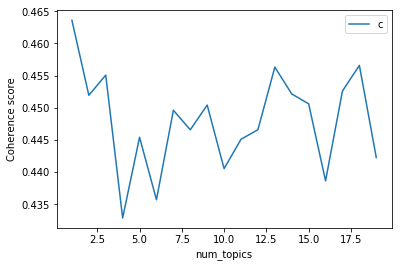

In [33]:
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=dsm, limit=20)